In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Behavior and personality prediction using HCP movie-watching data

In [2]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import numpy as np
import pandas as pd
import pickle
import os
from cc_utils import _get_clip_labels
from gru.rb_utils import (
    _get_results, get_cv_tbest, cv_agg,
    get_grid_acc, get_best_param,
    get_test_tbest, get_test_predictions,
    get_static, get_static_predictions)

# stats 
from scipy.stats import spearmanr

# plot
from matplotlib import pyplot
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = 'plotly_white'
from orig_scipts.plot_utils import (
    _hex_to_rgb, _plot_ts,
    _add_box, _highlight_max)
pio.orca.config.executable = '/home/joyneelm/fire/bin/orca'

colors = px.colors.qualitative.Plotly
ccc = {'Train': '#D55E00', 
    'Validation': '#CC79A7',
    'Test': '#CC79A7'}

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


## Important parameters for visualization

In [3]:
""" score: accuracy measure
    
    options:
        's': Spearman rank correlation
        'p': Pearson correlation
        'mse': mean-squared error
"""
score = 's'
pretty_score = 'Spearman rank correlation'

""" criteria for hyperparameter selection
    note: predictions are made for each clip
    
    options:
        'max': based on 'max/min' score across clips
        'mean': based on 'mean' score across clips
"""
criteria = 'mean'

## Model parameters and clip information

In [4]:
roi = 300
net = 7
subnet = 'wb'

zscore = 1
k_fold = 5
train_size = 100

In [5]:
clip_y = _get_clip_labels()
clip_y['testretest'] = 0
k_clip = len(np.unique(list(clip_y.values())))

clip_names = np.zeros(k_clip).astype(str)
clip_names[0] = 'testretest'
for key, item in clip_y.items():
    if item != 0:
        clip_names[item] = key
        
select_bhv = ['PMAT24_A_CR', 'PicVocab_Unadj',
              'NEOFAC_A', 'NEOFAC_E', 'NEOFAC_C',
              'NEOFAC_N', 'NEOFAC_O']

pretty_bhv = {}
for bhv in select_bhv:
    pretty_bhv[bhv] = bhv
pretty_bhv['PMAT24_A_CR'] = 'Fluid Intelligence'
pretty_bhv['PicVocab_Unadj'] = 'Verbal IQ'
print('Behavior / personality scores include:')
for bhv in select_bhv:
    print(pretty_bhv[bhv])

Behavior / personality scores include:
Fluid Intelligence
Verbal IQ
NEOFAC_A
NEOFAC_E
NEOFAC_C
NEOFAC_N
NEOFAC_O


In [6]:
class GRU_ARGS():
    roi = roi
    net = net
    subnet = subnet
    
    zscore = zscore
    k_fold = k_fold
    train_size = train_size
    
    # model
    model_type = 'gru'
    k_param = [32]
    param_str = 'k_hidden'
    k_layers = 1
    batch_size = 30
    num_epochs = [20]
    
    l2 = 0.0
    dropout=0.000001
    lr=0.001
    
    RES_DIR = 'results/bhv_{}'.format(model_type)
    
    select_bhv = select_bhv
    clip_names = clip_names
    clip_y = clip_y

In [7]:
class FF_ARGS():
    roi = roi
    net = net
    subnet = subnet
    
    zscore = zscore
    k_fold = k_fold
    train_size = train_size
    
    # model
    model_type = 'ff'
    k_param = [1]
    param_str = 'k_layers'
    k_hidden = 103
    batch_size = 30
    num_epochs = [20]
    
    RES_DIR = 'results/bhv_{}'.format(model_type)
    
    select_bhv = select_bhv
    clip_names = clip_names
    clip_y = clip_y

In [8]:
class TCN_ARGS():
    roi = roi
    net = net
    subnet = subnet
    
    zscore = zscore
    k_fold = k_fold
    train_size = train_size
    
    # model
    model_type = 'tcn'
    k_param = [5]
    param_str = 'k_wind'
    k_hidden = 25
    batch_size = 30
    num_epochs = [20]
    
    RES_DIR = 'results/bhv_{}'.format(model_type)
    
    select_bhv = select_bhv
    clip_names = clip_names
    clip_y = clip_y

In [9]:
class CPM_ARGS():
    roi = roi
    net = net
    subnet = subnet
    
    zscore = zscore
    k_fold = k_fold
    train_size = train_size
    
    # cpm
    model_type = 'cpm'
    k_param = [0.2]
    param_str = 'corr_thresh'
    
    RES_DIR = 'results/bhv_{}'.format(model_type)
    
    select_bhv = select_bhv
    clip_names = clip_names
    clip_y = clip_y

In [10]:
models = ['gru','ff','tcn','cpm']
pretty_model = {'gru': 'Gated Recurrent Unit',
                'ff': 'Feedforward Neural Network',
                'tcn': 'Temporal Convolutional Network',
                'cpm': 'Connectome-based Predictive Modeling'}
print('Models include:')
for model in models:
    print(f'{model.upper():5}: {pretty_model[model]}')

Models include:
GRU  : Gated Recurrent Unit
FF   : Feedforward Neural Network
TCN  : Temporal Convolutional Network
CPM  : Connectome-based Predictive Modeling


In [11]:
args = {}
args['gru'] = GRU_ARGS()
args['ff'] = FF_ARGS()
args['tcn'] = TCN_ARGS()
args['cpm'] = CPM_ARGS()

K_RUNS = 4

## Find best hyperparameters for behavior prediction

In [12]:
opt_hyperparam = {}
for model in models:
    opt_hyperparam[model] = {}
    for ii, bhv in enumerate(select_bhv):
        opt_hyperparam[model][bhv] = {}
        if model in ['gru','ff','tcn']:
            num_epoch, k_param = get_best_param(
                args[model], bhv, score = score, criteria = criteria)
            print('{:4} - {:20}: num_epochs = {:02}, {:10} = {}'.format(
                model, pretty_bhv[bhv], num_epoch, 
                args[model].param_str, k_param))
            opt_hyperparam[model][bhv]['num_epochs'] = num_epoch
            opt_hyperparam[model][bhv][args[model].param_str] = k_param
        elif model in ['cpm', 'bbs']:
            k_param = get_best_param(
                args[model], bhv, score = score, criteria = criteria)
            print('{:4} - {:20}: {} = {}'.format(
                model, bhv, args[model].param_str, k_param))
            opt_hyperparam[model][bhv][args[model].param_str] = k_param
    print('---')

32 20
gru  - Fluid Intelligence  : num_epochs = 20, k_hidden   = 32
32 20
gru  - Verbal IQ           : num_epochs = 20, k_hidden   = 32
32 20
gru  - NEOFAC_A            : num_epochs = 20, k_hidden   = 32
32 20
gru  - NEOFAC_E            : num_epochs = 20, k_hidden   = 32
32 20
gru  - NEOFAC_C            : num_epochs = 20, k_hidden   = 32
32 20
gru  - NEOFAC_N            : num_epochs = 20, k_hidden   = 32
32 20
gru  - NEOFAC_O            : num_epochs = 20, k_hidden   = 32
---
1 20
ff   - Fluid Intelligence  : num_epochs = 20, k_layers   = 1
1 20
ff   - Verbal IQ           : num_epochs = 20, k_layers   = 1
1 20
ff   - NEOFAC_A            : num_epochs = 20, k_layers   = 1
1 20
ff   - NEOFAC_E            : num_epochs = 20, k_layers   = 1
1 20
ff   - NEOFAC_C            : num_epochs = 20, k_layers   = 1
1 20
ff   - NEOFAC_N            : num_epochs = 20, k_layers   = 1
1 20
ff   - NEOFAC_O            : num_epochs = 20, k_layers   = 1
---
5 20
tcn  - Fluid Intelligence  : num_epochs = 20, k_w

## Get test score and prediction based on optimal hyperparameters

In [13]:
def get_score_and_predictions(args, star_hyper, score, max_order = 0):
    """get test accuracy and predictions at tbest
        
    Args:
        bhv_measures
        star_hyper: saved optimal hyperparameters
        score: 'p', 's', or 'mse'
        
    Return:
        test_acc: best score
        y_hat: predictions
        y: true scores
    """
    bhv_measures = args.select_bhv
    k_clips = len(clip_names)
    
    test_acc = {}
    clip_test_acc = {}
    y_hat, y = {}, {}
    fig = {}
    for ii, bhv in enumerate(bhv_measures):
        
        if args.model_type in ['gru','ff','tcn']:
            num_epochs = star_hyper[bhv]['num_epochs']
            k_param = star_hyper[bhv][args.param_str]
            r = _get_results(args, bhv, num_epochs, k_param)
            
            clip_test_acc[bhv] = np.zeros(len(clip_names))
            for jj, clip in enumerate(clip_names):
                _, V = get_test_tbest(args, clip, r, score)
                clip_test_acc[bhv][jj] = V

            if score != 'mse':
                best_clip = clip_names[np.argmax(clip_test_acc[bhv])]
                #test_acc[bhv] = np.max(clip_test_acc[bhv])
                test_acc[bhv] = np.flip(np.sort(clip_test_acc[bhv]))[max_order]
                
            else:
                best_clip = clip_names[np.argmin(clip_test_acc[bhv])]
                test_acc[bhv] = np.min(clip_test_acc[bhv])
                
            y_hat[bhv], y[bhv] = get_test_predictions(args, best_clip, 
                                                      r, score)
            
        elif args.model_type in ['cpm', 'bbs']:
            k_param = star_hyper[bhv][args.param_str]
            r = _get_results(args, bhv, k_param = k_param)
#             print(f"printing results {bhv}{model} :: {r['test_mode']['c_test_s']}")
            c_acc = np.zeros(k_clips)
            for jj, clip in enumerate(clip_names):
                _, V = get_static(args, clip, r, score, mode='test')
                c_acc[jj] = V

            if score != 'mse':
#                 print(f"c_acc is {c_acc}, score is {score}, bhv is {bhv}")
                clip_idx = np.flip(np.argsort(c_acc))[max_order]
                best_clip = clip_names[clip_idx]
                #best_clip = clip_names[np.argmax(c_acc)]
            else:
                best_clip = clip_names[np.argmin(c_acc)]

            _, test_acc[bhv] = get_static(args, best_clip, r, score,
                                          mode='test')

            y_hat[bhv], y[bhv] = get_static_predictions(args, best_clip, 
                                                        r, score)
        
        # df for px
        df = pd.DataFrame({'true': y[bhv],
                           'predicted':y_hat[bhv]})
        fig[bhv] = px.scatter(df, x='true', 
            y='predicted', trendline='ols')
        fig[bhv].update_layout(height=350, width=400,
                               title_text=pretty_bhv[bhv])
        fig[bhv].update_xaxes(dtick=0.2)
        fig[bhv].update_yaxes(dtick=0.2)
    
    return test_acc, y_hat, y, fig, clip_test_acc

Highest
                  bhv     GRU     CPM
0  Fluid Intelligence  0.3442  0.2900
1           Verbal IQ  0.2579  0.1442
2            NEOFAC_A  0.1502  0.0486
3            NEOFAC_E  0.2452  0.1183
4            NEOFAC_C  0.2552  0.1484
5            NEOFAC_N  0.1572  0.2143
6            NEOFAC_O  0.1910  0.2082


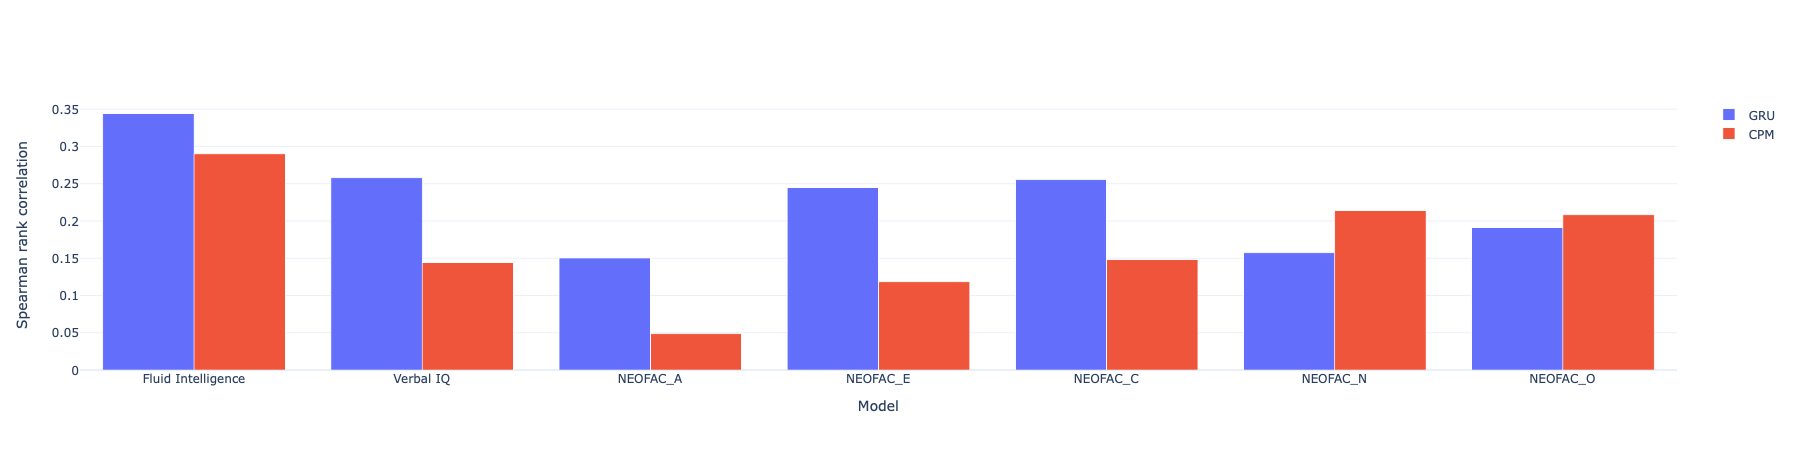

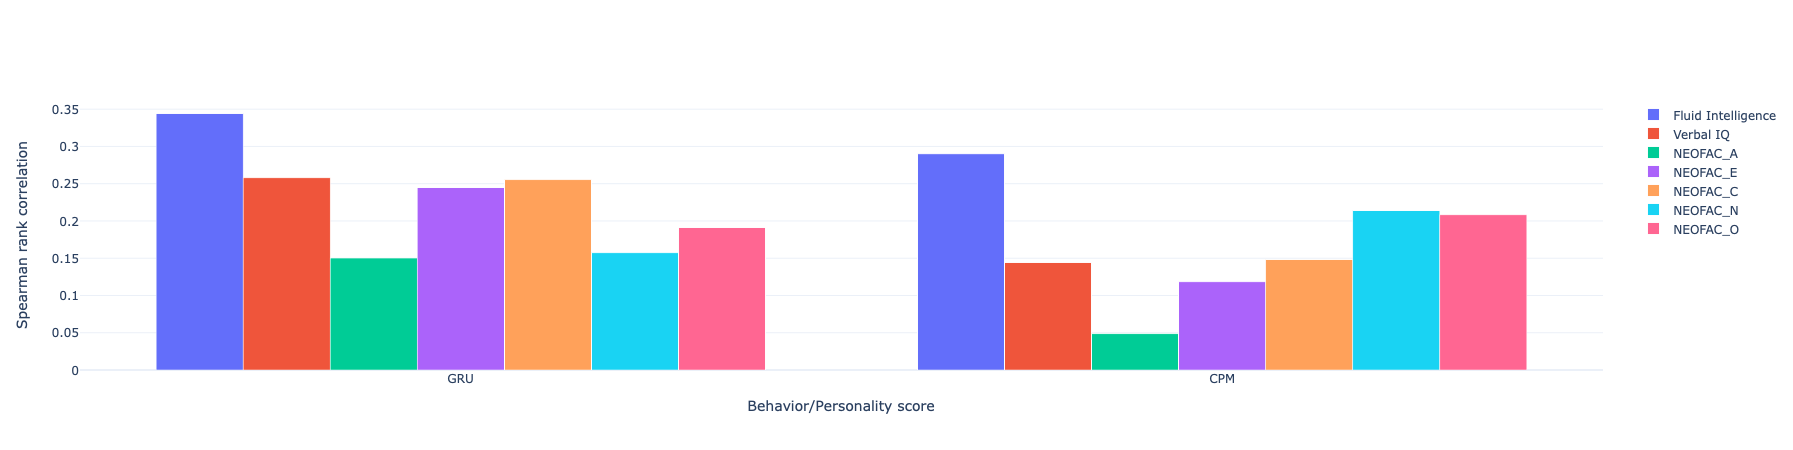

Second Highest
                  bhv     GRU     CPM
0  Fluid Intelligence  0.3265  0.2212
1           Verbal IQ  0.1557  0.1389
2            NEOFAC_A  0.1180  0.0422
3            NEOFAC_E  0.2300  0.0982
4            NEOFAC_C  0.2047  0.1144
5            NEOFAC_N  0.1217  0.1412
6            NEOFAC_O  0.1810  0.2063


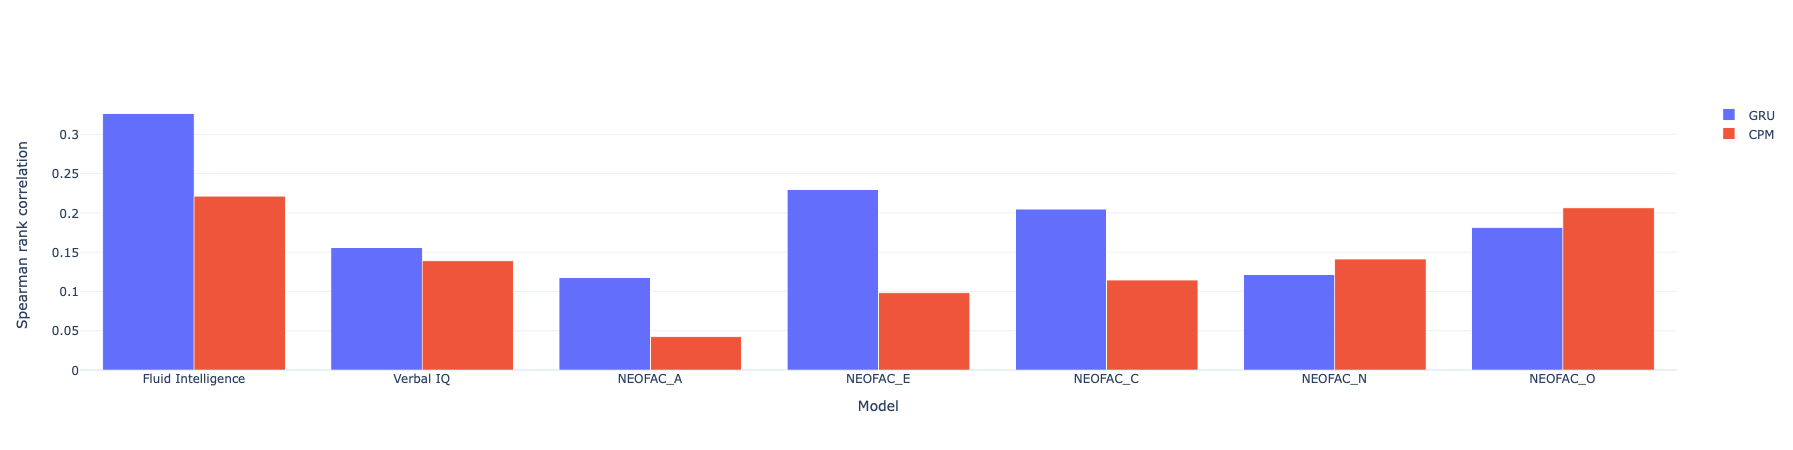

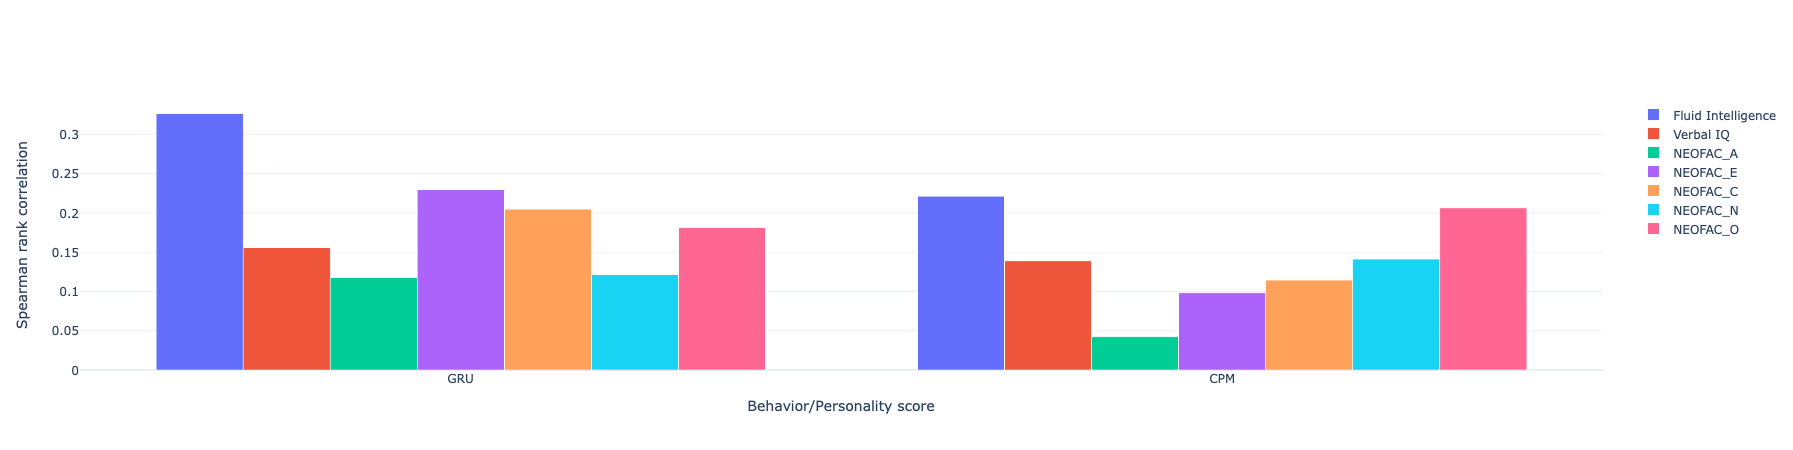

Third Highest
                  bhv     GRU     CPM
0  Fluid Intelligence  0.2267  0.1962
1           Verbal IQ  0.0954  0.1228
2            NEOFAC_A  0.1034  0.0118
3            NEOFAC_E  0.1996  0.0946
4            NEOFAC_C  0.1741  0.1075
5            NEOFAC_N  0.1029  0.1385
6            NEOFAC_O  0.1398  0.2043


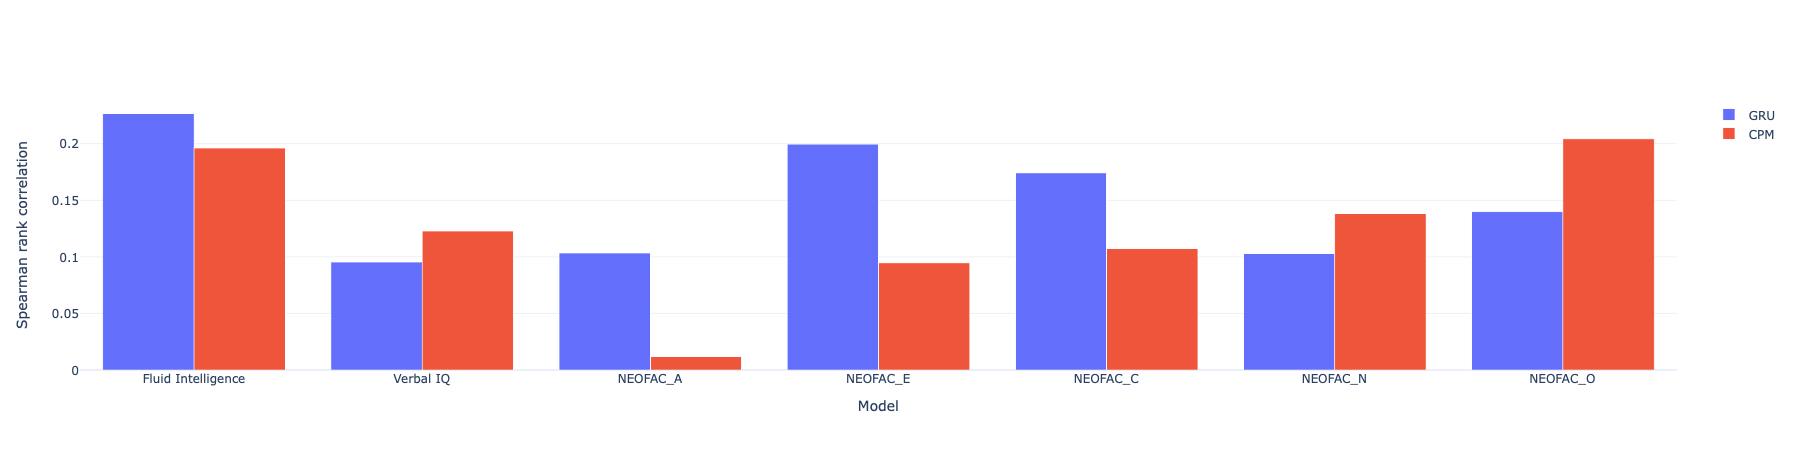

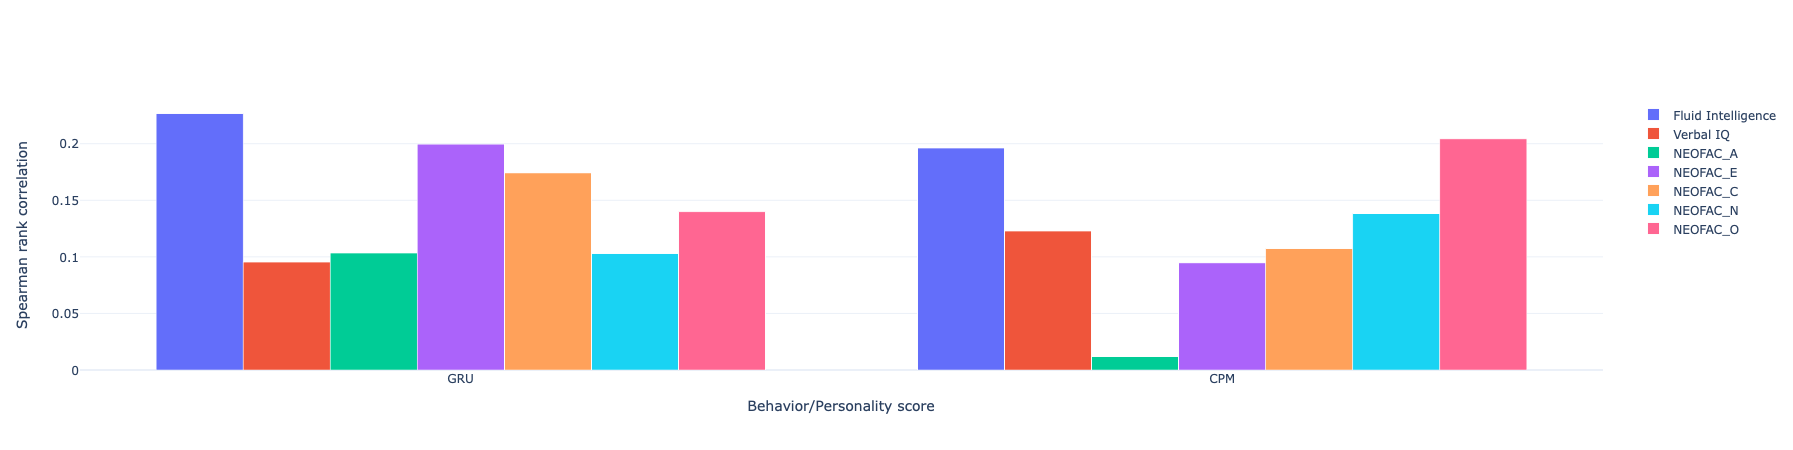

In [14]:
for max_order in range(3):
    if max_order == 0:
        print("Highest")
    elif max_order == 1:
        print('Second Highest')
    else:
        print('Third Highest')
        
    test_acc = {}
    save_y_hat, save_y = {}, {}

    #for model in models:
    for model in ['gru','cpm']:
        if model == 'gru':
            t_acc, pred, true, _, clip_t_acc = get_score_and_predictions(
                args[model], opt_hyperparam[model], score, max_order=max_order)
        else:
            t_acc, pred, true, _, _ = get_score_and_predictions(
            args[model], opt_hyperparam[model], score, max_order=max_order)
        test_acc[model] = t_acc
        save_y_hat[model] = pred
        save_y[model] = true


    best_score = {'bhv':[]}
    #for model in models:
    for model in ['gru','cpm']:
        best_score[model.upper()] = []
    for ii, bhv in enumerate(select_bhv):
        best_score['bhv'].append(pretty_bhv[bhv])
        #for model in models:
        for model in ['gru','cpm']:
            best_score[model.upper()].append(f'{test_acc[model][bhv]:.4f}')
    df = pd.DataFrame(best_score)
    print(df)

    fig = go.Figure()
    #for model in models:
    for model in ['gru','cpm']:
        y = []
        x = []
        for bhv in select_bhv:
            x.append(pretty_bhv[bhv])
            y.append(test_acc[model][bhv])
        bar = go.Bar(name = model.upper(),
                     x = x, y = y)
        fig.add_trace(bar)

    fig.update_layout(barmode = 'group')
    fig.update_xaxes(title_text = 'Model')
    fig.update_yaxes(title_text = pretty_score)
    fig.show()
    
    
    fig = go.Figure()
    for bhv in select_bhv:
        y = []
        x = []
        #for model in models:
        for model in ['gru','cpm']:
            x.append(model.upper())
            y.append(test_acc[model][bhv])
        bar = go.Bar(name = pretty_bhv[bhv],
                     x = x, y = y)
        fig.add_trace(bar)

    fig.update_layout(barmode = 'group')
    fig.update_xaxes(title_text = 'Behavior/Personality score')
    fig.update_yaxes(title_text = pretty_score)
    fig.show()

## Regression plot comparision using the highest scores from GRU and CPM

In [15]:
max_order = 0
test_acc = {}
save_y_hat, save_y = {}, {}

#for model in models:
for model in ['gru','cpm']:
    if model == 'gru':
        t_acc, pred, true, _, clip_t_acc = get_score_and_predictions(
            args[model], opt_hyperparam[model], score, max_order=max_order)
    else:
        t_acc, pred, true, _, _ = get_score_and_predictions(
        args[model], opt_hyperparam[model], score, max_order=max_order)
    test_acc[model] = t_acc
    save_y_hat[model] = pred
    save_y[model] = true

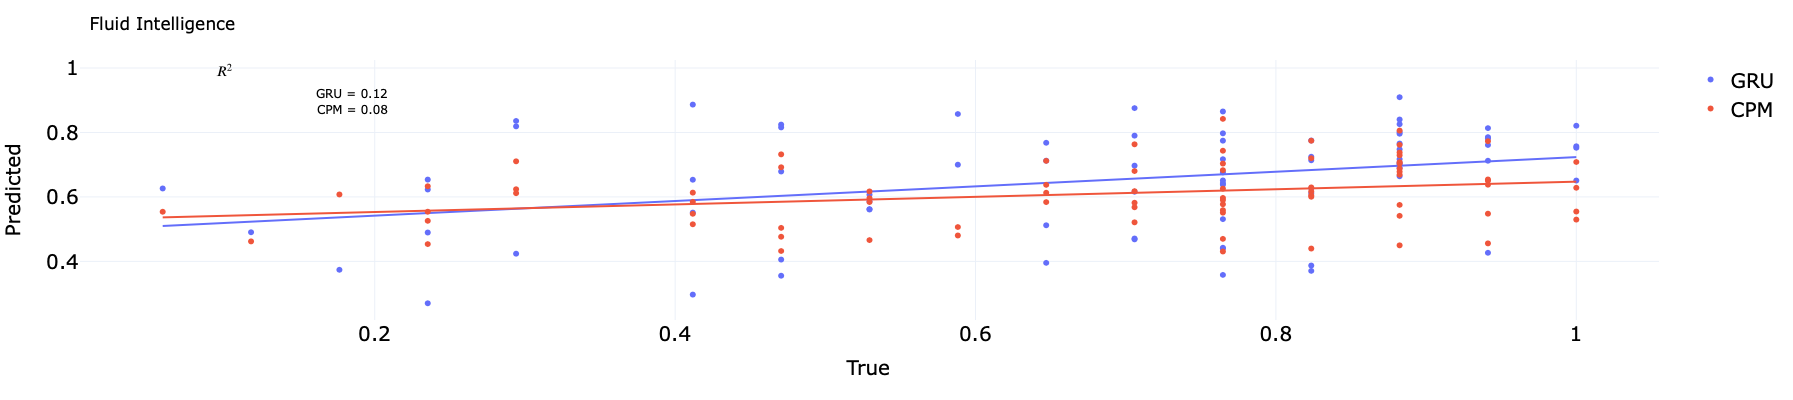

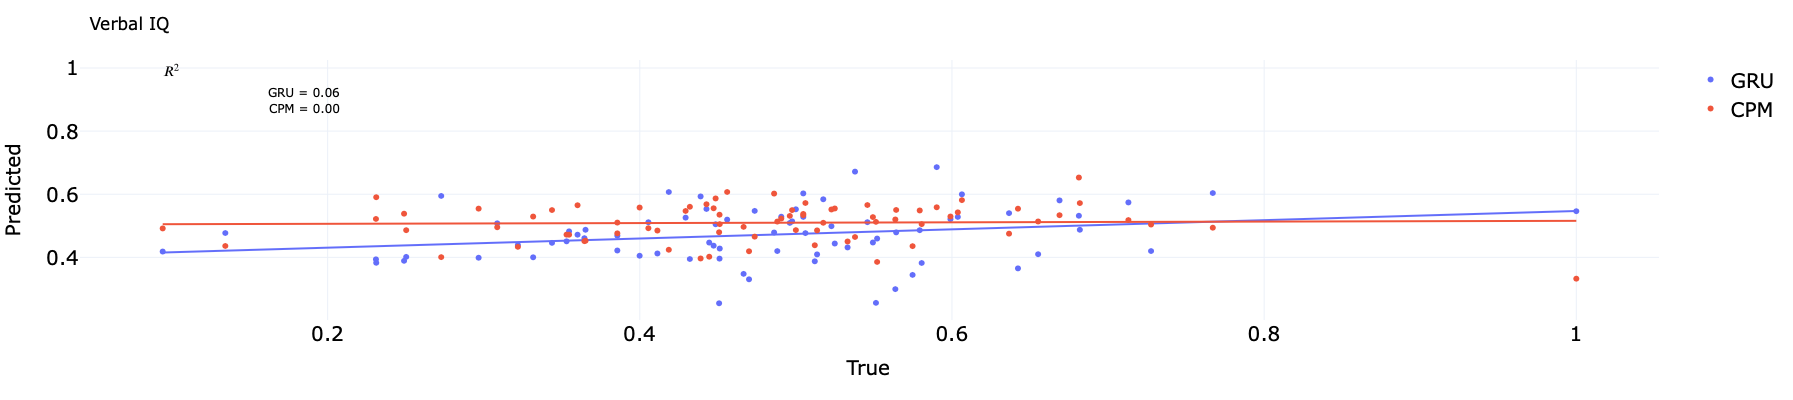

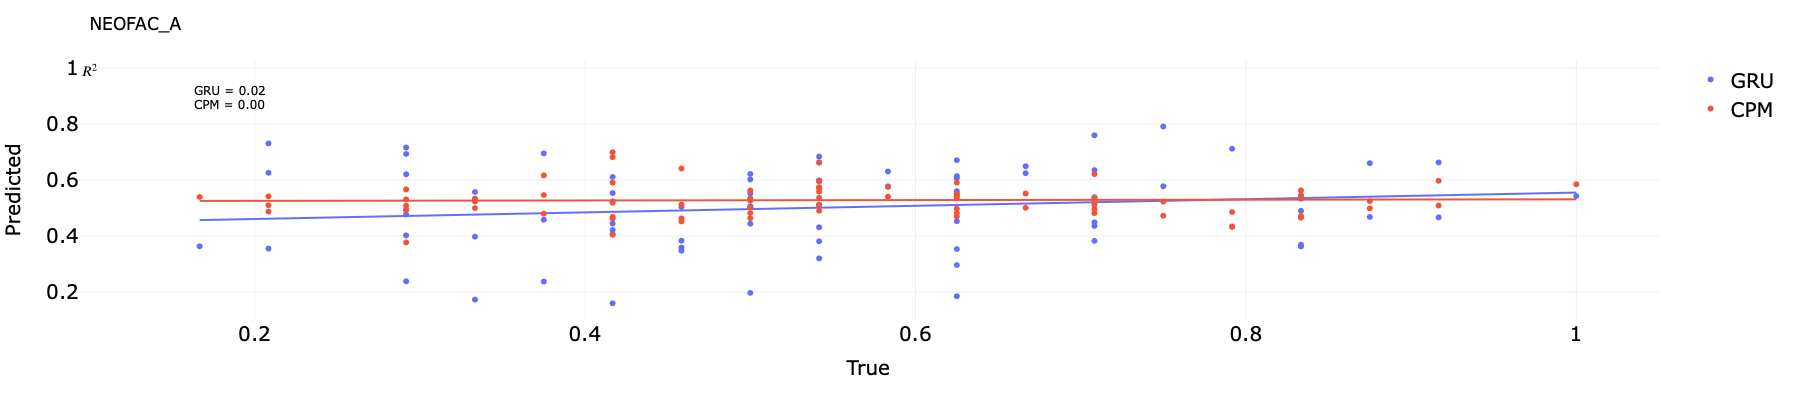

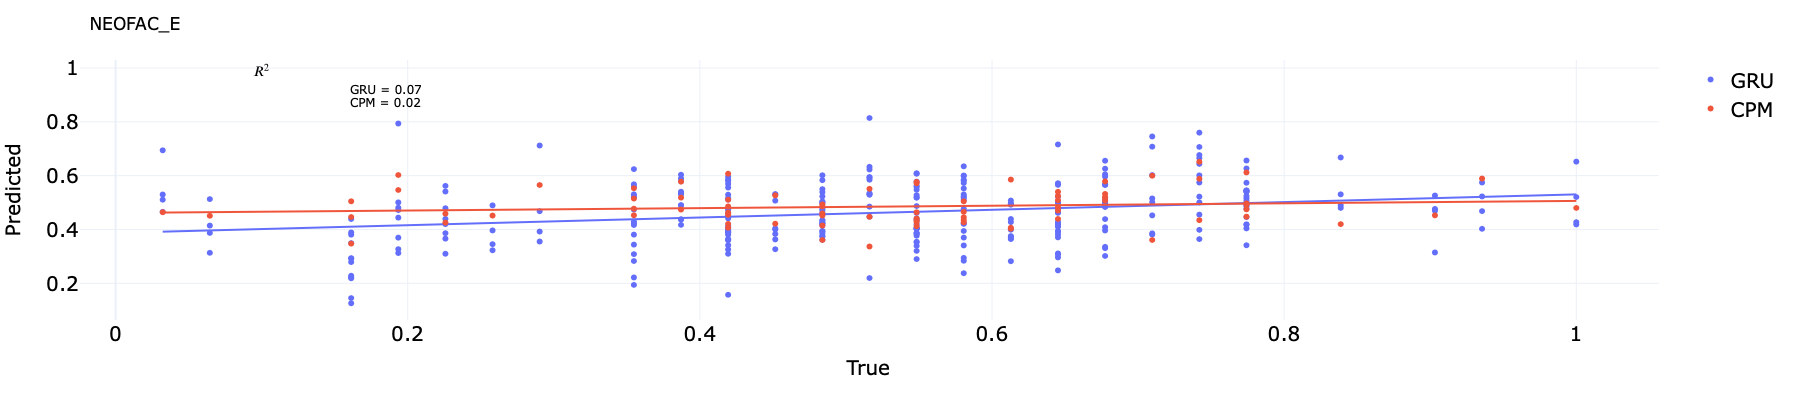

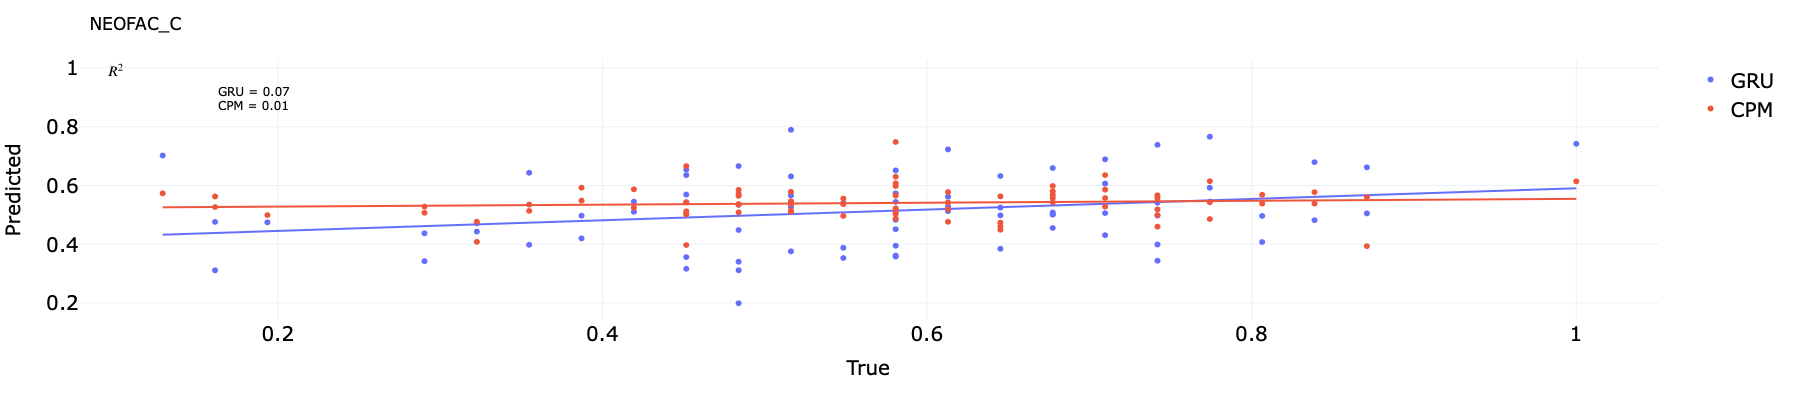

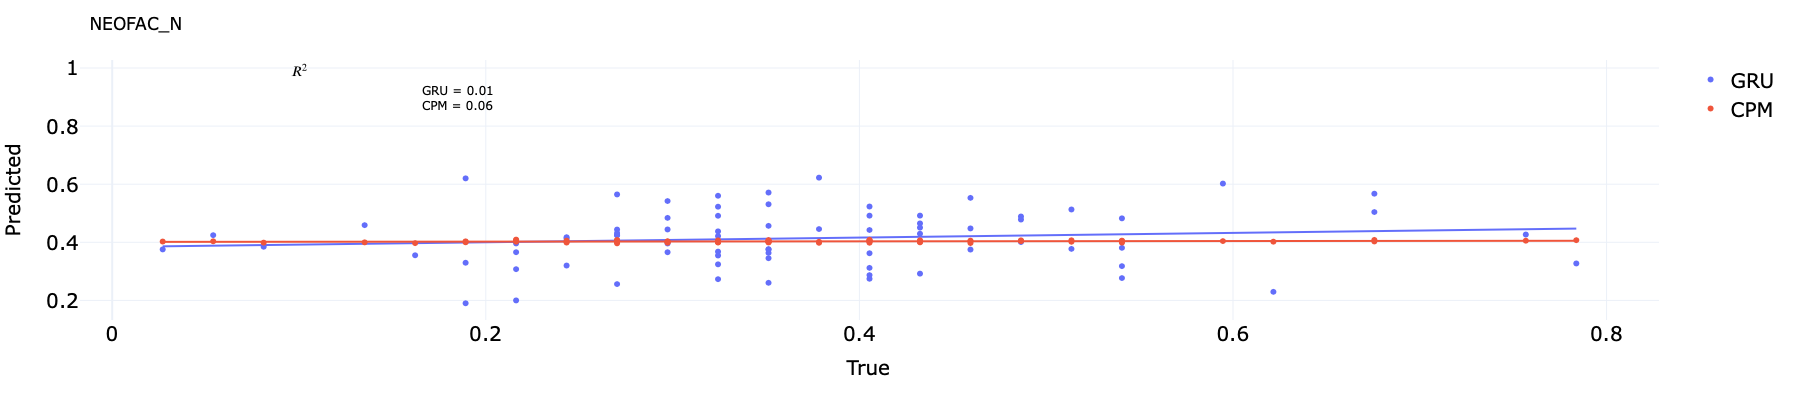

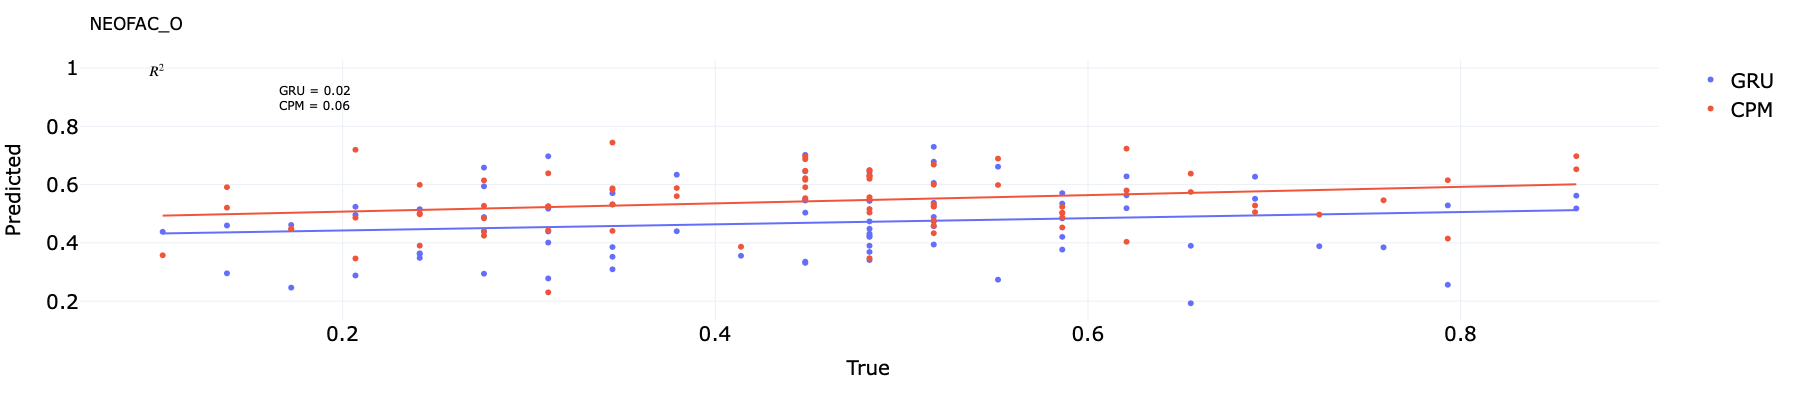

In [16]:
for bhv in select_bhv:
    plot_y, plot_y_hat = [], []
    plot_tag = []
    #for model in models:
    for model in ["gru","cpm"]:
        plot_y += list(save_y[model][bhv])
        plot_y_hat += list(save_y_hat[model][bhv])
        k_sub = len(save_y[model][bhv])
        plot_tag += [model.upper()]*k_sub

    # df for px
    df = pd.DataFrame(
        {'true': plot_y, 'predicted': plot_y_hat,
         'tag': plot_tag})
    
    fig = px.scatter(df, x='true', y='predicted', 
                     color='tag', trendline='ols')
    
    fig.update_layout(height=400, width=480,
                      title_text=pretty_bhv[bhv],
                      font_color='black',
                      legend_font_size=20,
                      legend_title_text= ''
                     )
    
    fig.update_xaxes(dtick=0.2, tickfont=dict(size=20),
                     title=dict(text='True',
                                font_size=20))
    fig.update_yaxes(dtick=0.2, tickfont=dict(size=20),
                     title=dict(text='Predicted',
                                font_size=20))
    
    gru_r2, cpm_r2 = [px.get_trendline_results(fig).px_fit_results.iloc[i].rsquared for i in range(2)]
    
    fig.add_annotation(x=0.1,y=1,text='$R^2$',
                       showarrow=False)
    fig.add_annotation(x=0.185,y=0.925,text=f'GRU = {gru_r2:.2f}',
                       showarrow=False)
    fig.add_annotation(x=0.185,y=0.875,text=f'CPM = {cpm_r2:.2f}',
                       showarrow=False)
    
    fig.show()

## Heatmap showing spearman correlation

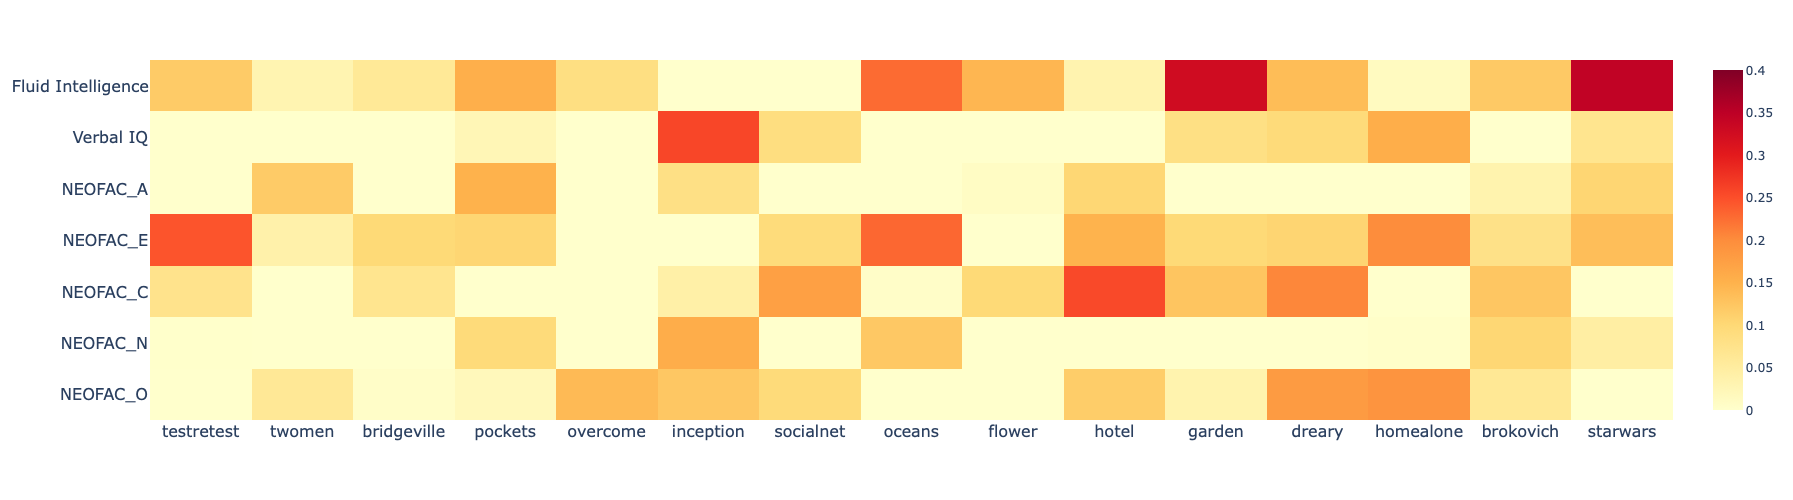

In [17]:
heatmap = pd.DataFrame(clip_t_acc,index=clip_names)
heatmap.rename(columns=pretty_bhv,inplace=True)
heatmap = heatmap.T

fig = px.imshow(heatmap.values,x=heatmap.columns,
                y=heatmap.index,
                color_continuous_scale='YlOrRd',
                zmin=0.,zmax=0.4, aspect=1,
                height=500)

fig.update_xaxes(side="bottom",tickfont_size=16)
fig.update_yaxes(tickfont_size=16)
fig.show()

## Temporal spearman correlation score

In [18]:
def _null_window(args, bhv, num_epochs, k_param, clipnames, mode='test', win_len = 1):

    '''
    compare temporal accuracy for each model
    '''
    
    def moving_average(A, win_len):
        
        if win_len == 1:
            return A
        
        ret = np.cumsum(A, axis=0, dtype=float)
        ret[win_len:] = ret[win_len:] - ret[:-win_len]
        return ret[win_len - 1:] / win_len
    
    k_class = len(clip_names)
    k_rows = int(np.ceil(k_class/3))
    k_cols = 3
    fig = make_subplots(rows=k_rows, cols=k_cols, 
        subplot_titles=clipnames, print_grid=False)

    r, r_perm = _get_results(args, bhv, num_epochs, k_param, perm=True)
    if mode=='train':
        tag = 'train_mode'
        subtag = 't_train_s'
    elif mode=='test':
        tag = 'test_mode'
        subtag = 't_test_s'

    for jj in range(k_class):
#         if jj != 14:
#             continue

        showlegend = False
        if jj == 0:
            showlegend = True
        row = int(jj/k_cols) + 1
        col = (jj%k_cols) + 1
        
        acc = r[tag][subtag][jj]
        null_acc = r_perm[tag][subtag][jj]
        
        acc = moving_average(acc, win_len)
        null_acc_list = []
        for i in range(null_acc.shape[0]):
            null_acc_list.append(moving_average(null_acc[i, :], win_len))
        null_acc = np.nan_to_num(np.stack(null_acc_list, axis=0))
        
        max_acc = np.max(acc)
        max_null_acc = np.amax(null_acc, axis=1)
#         max_null_acc /= np.sum(max_null_acc)
        s = np.random.normal(np.mean(max_null_acc), np.std(max_null_acc), 1000)
        
        import plotly.figure_factory as ff
        group_labels=['null distribution of maxes']
        figg = ff.create_distplot([max_null_acc],
                                 group_labels,
                                 bin_size=.01,
                                 histnorm='probability density',
                                 show_rug=False,
                                 show_curve=True,
                                 show_hist=True,
                                 curve_type='normal',
                                 colors=['#939393']*20)
        
        fig.add_trace(figg.data[0], row=row, col=col)
        fig.add_shape(go.layout.Shape(type="line",
                                        yref="y",
                                        xref="x",
                                        x0=max_acc,
                                        y0=0,
                                        x1=max_acc,
                                        y1=12,
                                        line=dict(color=colors[0], width=5),name='max(GRU)'), row=row, col=col)
        from scipy.stats import norm
        pval = 1 - norm.cdf((max_acc - np.mean(max_null_acc))/ np.std(max_null_acc))
        if jj == 4:
            textposition = "top right"
        else: 
            textposition = "top left"
#         if pval < 0.11:
#             if pval < 0.03:
#                 pcolor = 'green'
#             else:
#                 pcolor = '#FF8C00'
#         else:
        pcolor = 'black'
        fig.add_trace(go.Scatter(
            x=[max_acc],
            y=[10],
            mode="text",
            text=["  p={:.4f}  ".format(round(pval,4))],
            textposition=textposition,
            textfont=dict(size=30, color=pcolor),
            showlegend=False
        ), row=row, col=col)
        from scipy import stats
        xrange = np.arange(0,0.5,0.0025)
        
        fig.add_trace(go.Scatter(x=xrange, 
                  y=stats.norm(loc=np.mean(max_null_acc), scale=np.std(max_null_acc)).pdf(xrange), 
                  mode='lines',
                  line=dict(width=5, color='#939393'),
                  name='Normal',
                  showlegend=False
                 ), row, col)
        
    for i in fig['layout']['annotations']:
        i['font'] = dict(size=30,color='Black')
    return fig, pval

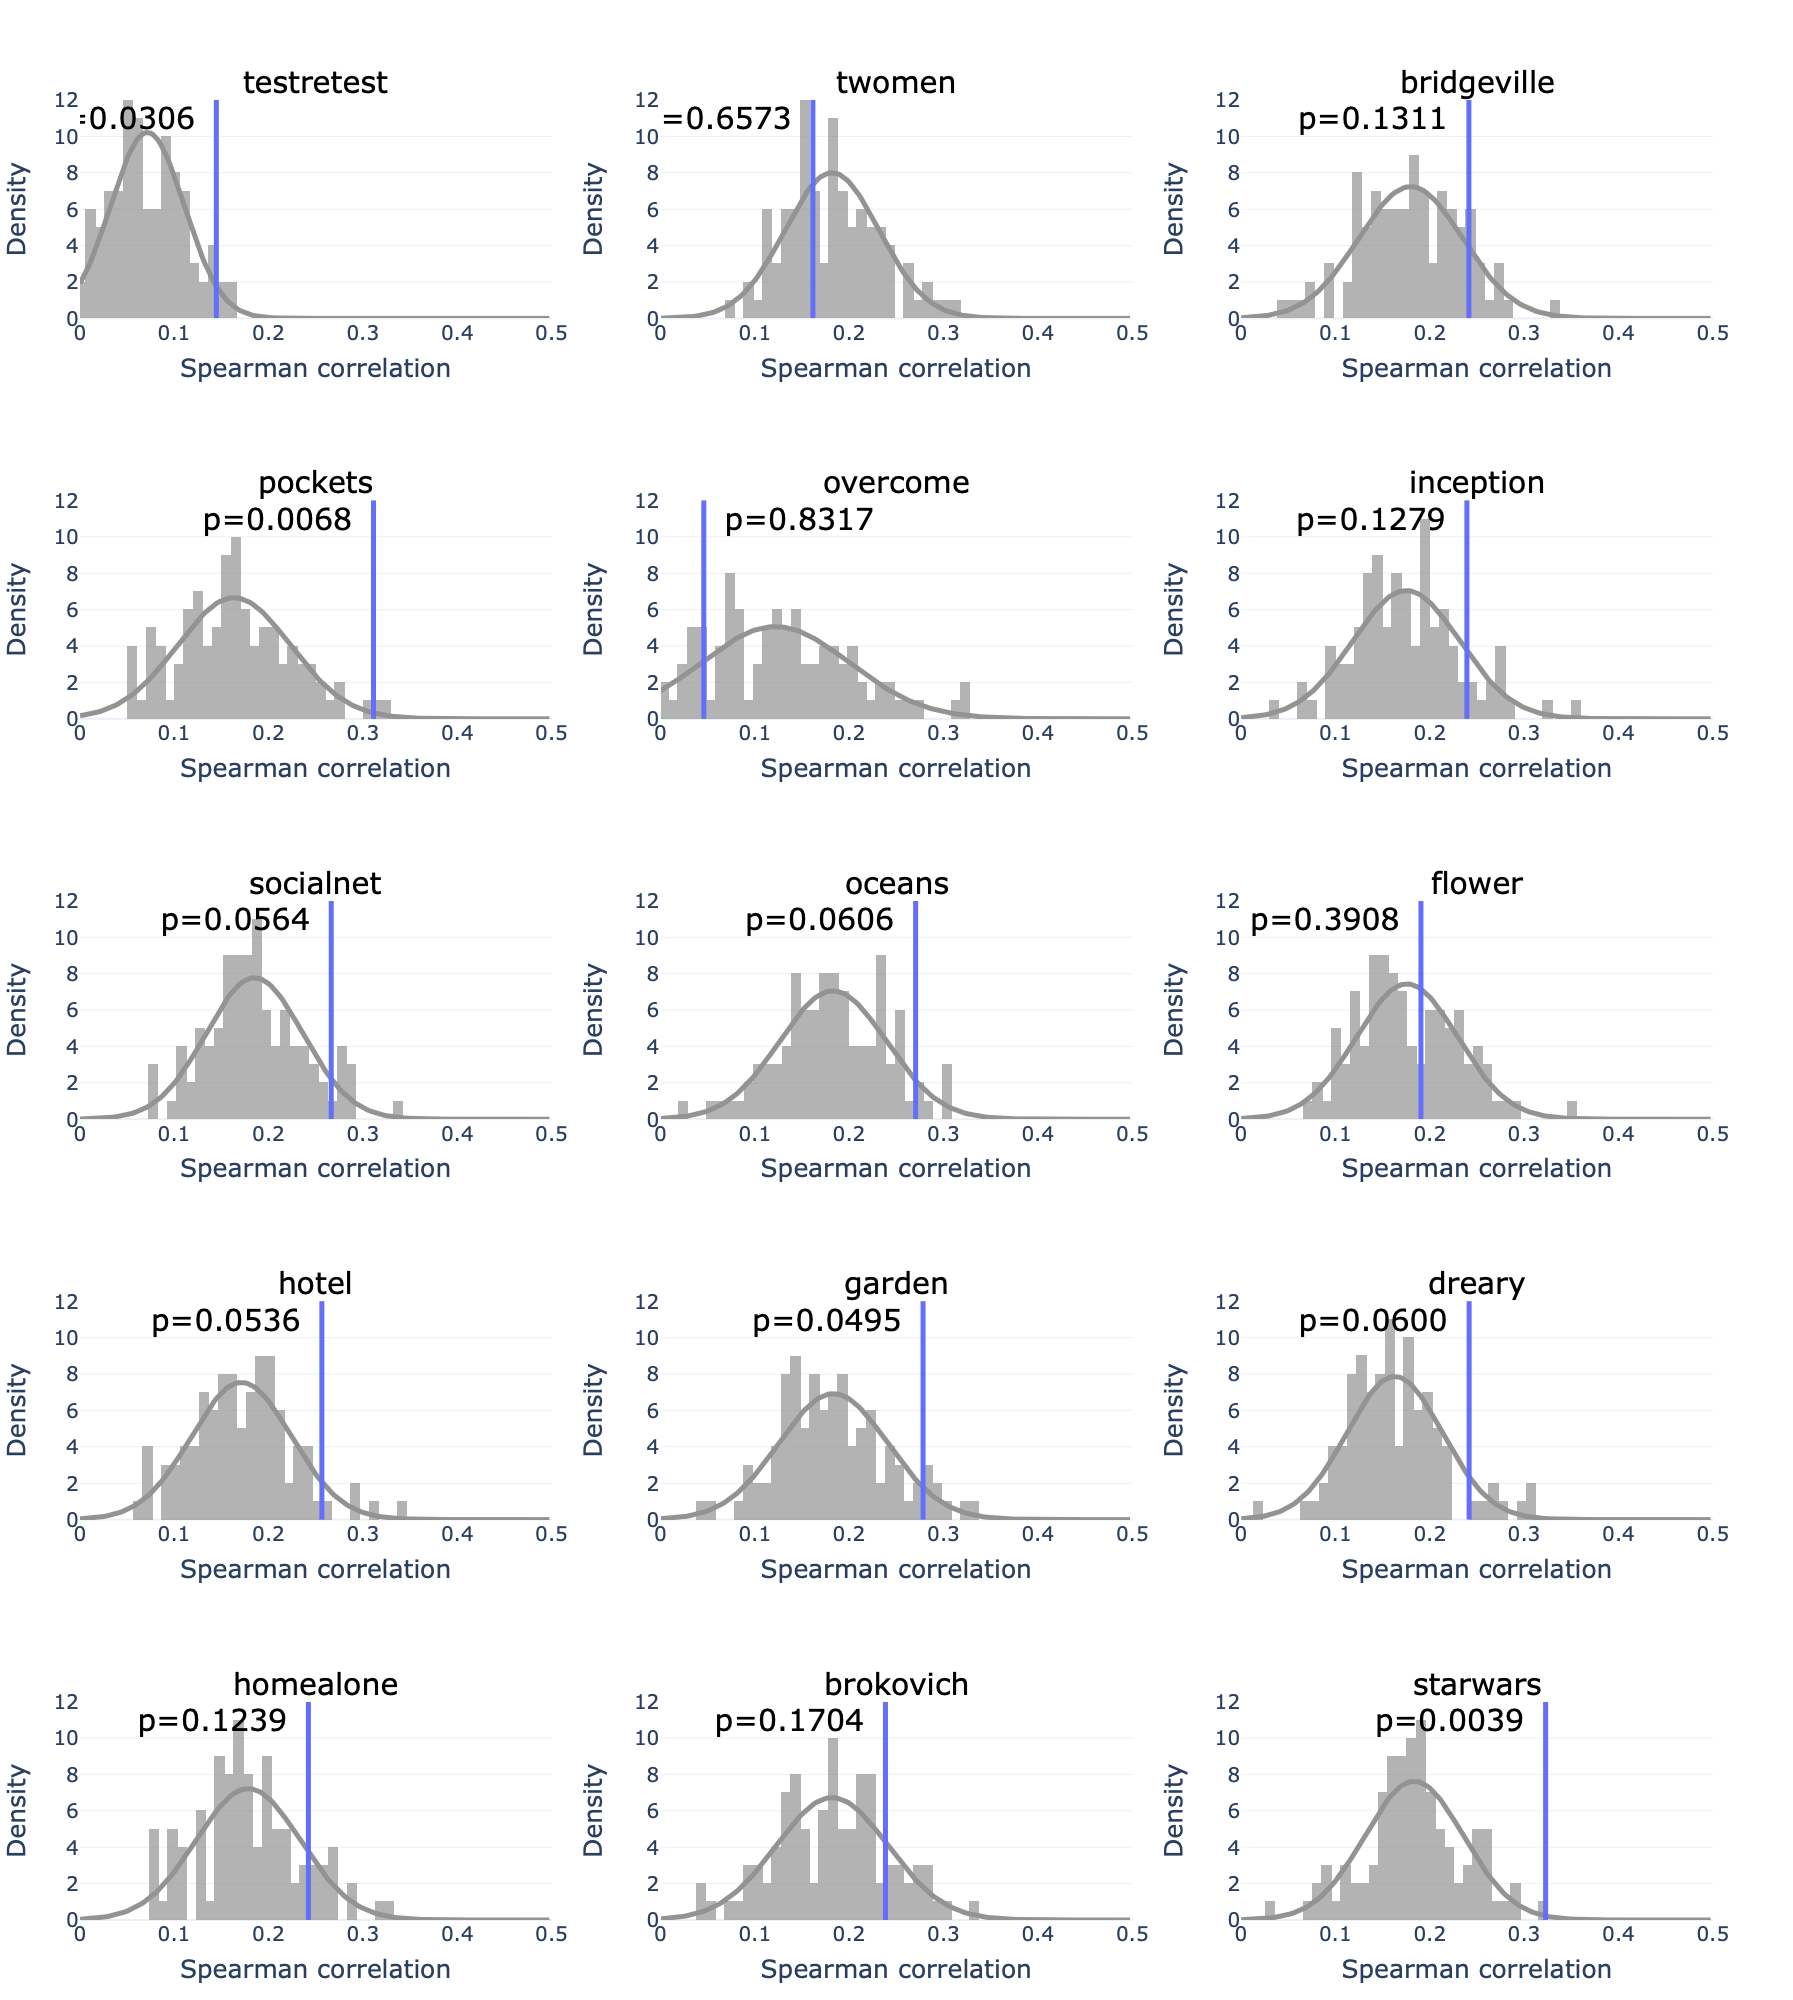

In [23]:
# cpm scores for fluid intelligence for all clips
model = 'cpm'
bhvname = list(pretty_bhv.keys())[1]
star_hyper = opt_hyperparam[model]
k_param = star_hyper[bhv][args[model].param_str]
r = _get_results(args[model], bhvname, k_param = k_param)

k_clips = 15

c_acc = np.zeros(k_clips)
for jj, clip in enumerate(clip_names):
    _, V = get_static(args[model], clip, r, score, mode='test')
    c_acc[jj] = V

cpm_best = np.max(c_acc)
cpm_starwars = c_acc[14]

max_time = 260
winlen = 10

# gru temporal scores
for bhv in pretty_bhv.keys():
    if bhv != bhvname: continue
    fig, pval = _null_window(
        args['gru'], bhv, args['gru'].num_epochs[0], 32, clip_names, win_len=winlen)
    fig.update_layout(height=2000, width=1800, showlegend=False)
#     fig.update_layout(legend=dict(yanchor="top", orientation="h", y=0.99, xanchor="left", x=0.01, font = dict(size = 20)))
    fig.update_yaxes(tickfont=dict(size=20), titlefont=dict(size=25), range=[0,12],
                     title_text='Density')
    fig.update_xaxes(tickfont=dict(size=20), titlefont=dict(size=25), 
                     range = [0,0.5], title_text='Spearman correlation')
    fig.show()
    fig.write_image(file=f"figures/bhv/supp_fig5_{bhvname}_pvals.png",
                format="png", 
                scale=None,
                width=None, 
                height=None, 
                validate=True)
    

In [20]:
def _compare_temporal(args, bhv, num_epochs, k_param, clipnames, mode='test', win_len = 1, c_acc=None):

    '''
    compare temporal accuracy for each model
    '''
    
    def moving_average(A, win_len):
        
        if win_len == 1:
            return A
        
        ret = np.cumsum(A, axis=0, dtype=float)
        ret[win_len:] = ret[win_len:] - ret[:-win_len]
        return ret[win_len - 1:] / win_len
    
    def get_ranges(nums):
            nums = sorted(set(nums))
            gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s+1 < e]
            edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
            return list(zip(edges, edges))
    
    k_class = len(clip_names)
    k_rows = int(np.ceil(k_class/3))
    k_cols = 3
    fig = make_subplots(rows=k_rows, cols=k_cols, 
        subplot_titles=clipnames, print_grid=False)

    fig_clip = {}
    for clip in clipnames:
        fig_clip[clip] = go.Figure()

    r, r_perm = _get_results(args, bhv, num_epochs, k_param, perm=True)
    if mode=='train':
        tag = 'train_mode'
        subtag = 't_train_s'
    elif mode=='test':
        tag = 'test_mode'
        subtag = 't_test_s'

    max_time = -100
    for jj in range(k_class):
#         if jj != 14:
#             continue

        row = int(jj/k_cols) + 1
        col = (jj%k_cols) + 1

        showlegend = False
#         if jj == 0:
#             showlegend = True
        
#         print(r[tag][subtag][1])
        acc = r[tag][subtag][jj]
        print(f"argmax for {clipnames[jj]} is {np.argmax(acc)+1}")
        acc = moving_average(acc, win_len)
        ts = {'mean': acc, #np.mean(acc, axis=0),
              'ste': 0* 1/np.sqrt(len(acc)) * np.std(acc, axis=0)}
        
        null_acc = r_perm[tag][subtag][jj]
        null_acc_avg = [] 
        for idx_ts in range(null_acc.shape[0]):
            null_acc_avg.append(moving_average(null_acc[idx_ts], win_len))
        null_acc_avg = np.stack(null_acc_avg, axis=0)
        ts_null = {'mean': np.mean(null_acc_avg, axis=0),
                   'ste': 1.96 * np.std(null_acc_avg, axis=0)}
        
        dur_above_chance = np.where(ts['mean'] > ts_null['mean'] + ts_null['ste'])[0]
        
        
        if len(dur_above_chance) != 0:
            ranges = get_ranges(dur_above_chance)
#             print(len(dur_above_chance))
            for pair in ranges:
                print(pair[0], pair[1])
                fig.add_trace(go.Scatter(x=np.arange(pair[0], pair[1]+1), y=-0.2*np.ones(pair[1]-pair[0]+1), mode='lines', name='feasible', line=dict(color='black', width=10), showlegend=False), row, col)
        plotter = {'tr':go.Scatter(x=np.arange(1, acc.shape[0]+1), y=acc, mode='lines', name='GRU', line=dict(color=colors[0], width=5), showlegend=showlegend)}
        for trace in plotter:
            fig.add_trace(plotter[trace], row, col)
        for trace in plotter:
            fig_clip[clipnames[jj]].add_trace(plotter[trace])
#         fig.add_trace(go.Scatter(x=np.arange(1, acc.shape[0]+1), y=np.max(c_acc)*np.ones(acc.shape[0]), mode='lines', name='CPM best', showlegend = showlegend, line=dict(color='maroon', width=3)), row, col)
        fig.add_trace(go.Scatter(x=np.arange(1, acc.shape[0]+1), y=c_acc[jj]*np.ones(acc.shape[0]), mode='lines', name='CPM starwars', showlegend = showlegend, line=dict(color='red', width=3)), row, col)

        
#         plotter = _plot_ts(ts, colors[0],
#             showlegend=True, name='GRU', width=3)
        
            
        plotter = _plot_ts(ts_null, '#939393',#colors[1],
            showlegend=showlegend, name=bhv, width = 0)
        for trace in plotter:
            fig.add_trace(plotter[trace], row, col)
        for trace in plotter:
            fig_clip[clipnames[jj]].add_trace(plotter[trace])

        if len(ts['mean']) > max_time:
            max_time = len(ts['mean'])

    fig.update_layout(height=int(400*k_rows), width=600,
        legend_orientation='h')
    fig.update_xaxes(range=[0, max_time], dtick=30, 
        title_text='time (in s)',
        showgrid=False,
        autorange=False,
        tickfont=dict(size=30),
        titlefont=dict(size=30))
    fig.update_yaxes(range=[-0.2 -0.01, 0.5], dtick=0.2, title_text='Spearman correlation',
        gridwidth=1, gridcolor='#bfbfbf',tickfont=dict(size=30), titlefont=dict(size=30),
        autorange=False)
    for i in fig['layout']['annotations']:
            i['font'] = dict(size=30,color='Black')

    return fig, fig_clip

[ 0.12281471  0.12133971  0.01738893  0.06179084  0.03792208  0.14419686
 -0.01933014  0.05033493 -0.2212987   0.05126452 -0.07898838 -0.02567327
  0.06925496  0.01268626  0.13889269]
argmax for testretest is 55
1 1
3 3
37 37
41 41
48 52
54 58
argmax for twomen is 82
79 81
205 205
238 238
argmax for bridgeville is 151
0 1
95 97
108 110
112 115
149 151
166 168
217 217
219 220
argmax for pockets is 44
3 5
41 51
55 55
92 100
104 104
argmax for overcome is 53
argmax for inception is 202
25 26
29 30
83 84
108 109
149 149
155 159
176 176
180 182
193 193
200 202
205 206
argmax for socialnet is 237
106 110
180 180
182 182
234 239
argmax for oceans is 137
0 0
40 44
81 82
108 111
126 128
131 131
133 138
140 140
142 147
238 238
242 243
argmax for flower is 16
14 15
54 54
59 59
120 120
argmax for hotel is 119
42 42
68 68
70 70
72 72
97 101
110 111
114 116
118 119
122 122
182 183
argmax for garden is 75
5 5
10 12
57 57
59 60
71 77
139 139
151 151
191 191
argmax for dreary is 71
19 19
23 23
25 25
68

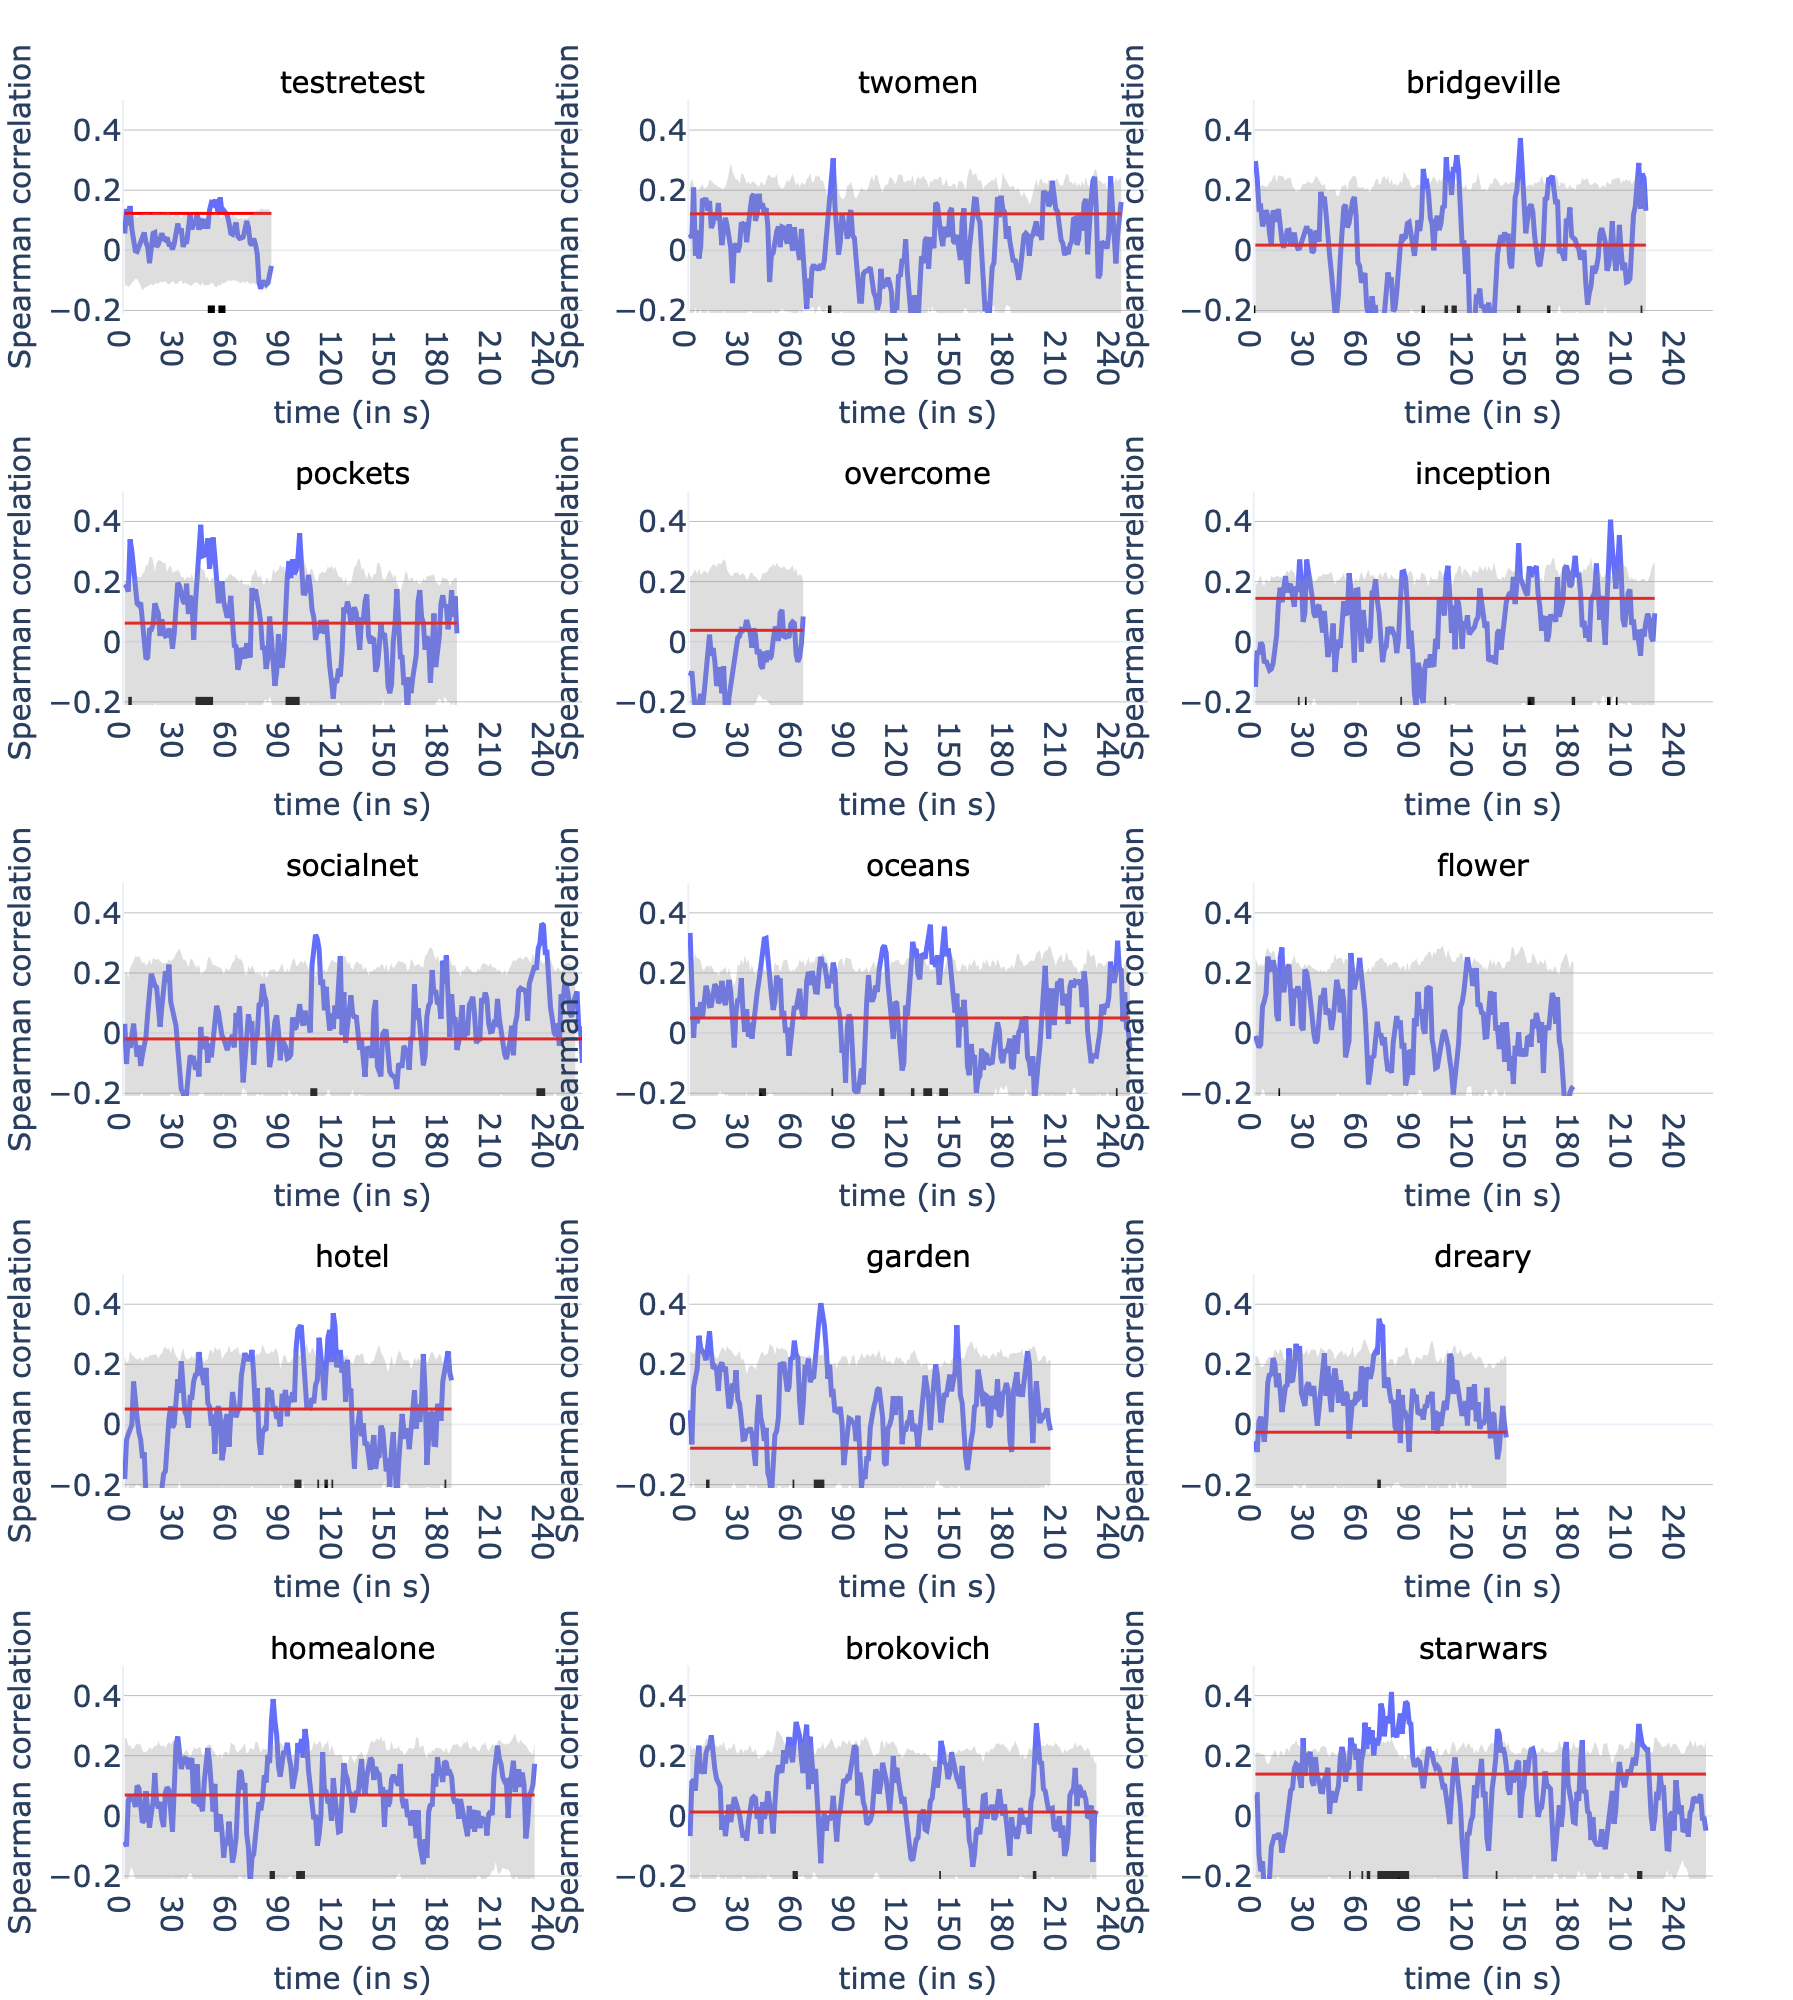

In [21]:
# cpm scores for fluid intelligence for all clips
model = 'cpm'
bhvname = list(pretty_bhv.keys())[1]
star_hyper = opt_hyperparam[model]
k_param = star_hyper[bhv][args[model].param_str]
r = _get_results(args[model], bhvname, k_param = k_param)

k_clips = 15

c_acc = np.zeros(k_clips)
for jj, clip in enumerate(clip_names):
    _, V = get_static(args[model], clip, r, score, mode='test')
    c_acc[jj] = V

print(c_acc)

# best cpm score with any clip
cpm_best = np.max(c_acc)
cpm_starwars = c_acc[14]
# cpm_best_scores = [float(best_score['CPM'][i]) for i in range(7)]
# cpm_best = max(cpm_best_scores)
# print(cpm_best)

max_time = 260
winlen=1

# gru temporal scores
for bhv in pretty_bhv.keys():
    if bhv != bhvname: continue
    fig, fig_clip = _compare_temporal(
        args['gru'], bhv, args['gru'].num_epochs[0], 32, clip_names, win_len=winlen, c_acc=c_acc)
    fig.update_layout(height=2000, width=1800)
#     fig.update_layout(legend=dict(
#     yanchor="top", orientation="v", y=0.99, xanchor="left", x=0.01, font = dict(size = 25), bgcolor='rgba(0,0,0,0)'))
    fig.show()
    fig.write_image(file=f"figures/bhv/supp_fig5_{bhvname}.png",
                format="png", 
                scale=None,
                width=None, 
                height=None, 
                validate=True)
    

In [22]:
180-128+1

53